# Predicting Student Dropout Risk in a University

### Overview
A university is concerned about the increasing number of students dropping out before completing their degrees. The academic board has collected data about students’ academic, personal, and socio-economic backgrounds. They want to use machine learning to predict whether a student is at risk of dropping out, so that proactive intervention can be made.

In [758]:
#!pip install xgboost

In [759]:
## importing Neccessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#for scaling the continuous columns
from sklearn.preprocessing import StandardScaler

#for spliting the dataset into train and test set
from sklearn.model_selection import train_test_split

#importing a classifer models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

#importing metrics
from sklearn.metrics import classification_report, roc_auc_score

# using smote for the data imbalance
from imblearn.over_sampling import SMOTE

In [760]:
## Importing the dataset given
df = pd.read_csv('student_data_with_missing_outliers.csv')
df.head(5)

,student_id,age,gender,department,GPA,attendance_rate,financial_aid,parent_education_level,hours_studied_per_week,internet_access,dropout
0,S1000,22,Male,CS,3.30,56.83,Yes,Primary,13.4,Yes,No
1,S1001,19,Male,CS,4.28,64.55,No,Tertiary,10.9,Yes,No
2,S1002,28,Male,CS,3.90,49.83,Yes,Tertiary,9.0,Yes,No
3,S1003,26,Male,CE,2.36,85.07,Yes,Tertiary,7.1,Yes,No
4,S1004,23,Female,CE,3.24,57.82,No,Secondary,19.5,Yes,No


#### Dataset Description

| Column Name             | Description                                      |
|-------------------------|--------------------------------------------------|
| student_id              | Unique student identifier                        |
| age                     | Age of the student                               |
| gender                  | Male or Female                                   |
| department              | Department name (e.g., CS, EE, ME)                |
| GPA                     | Grade Point Average (0.0 - 5.0)                   |
| attendance_rate         | Percentage of classes attended                   |
| financial_aid           | Yes or No                                        |
| parent_education_level  | Highest education level of parent                |
| hours_studied_per_week  | Average weekly study hours                       |
| internet_access         | Whether student has regular internet access      |
| dropout                 | Target variable (Yes = dropout, No = retained)   |

#### Data Preprocessing

#### Deliverables 1: Identify and handle missing values

In [764]:
# Checking the dataset
print(f'The dataset contains observations from {df.shape[0]} students with {df.shape[1]} attributes')

The dataset contains observations from 1000 students with 11 attributes


In [765]:
# cvhecking the overall dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   student_id              1000 non-null   object 
 1   age                     1000 non-null   int64  
 2   gender                  1000 non-null   object 
 3   department              1000 non-null   object 
 4   GPA                     950 non-null    float64
 5   attendance_rate         950 non-null    float64
 6   financial_aid           950 non-null    object 
 7   parent_education_level  843 non-null    object 
 8   hours_studied_per_week  951 non-null    float64
 9   internet_access         1000 non-null   object 
 10  dropout                 1000 non-null   object 
dtypes: float64(3), int64(1), object(7)
memory usage: 86.1+ KB


From the dataset information above, these are the observations noticed
- There are missing values in the GPA, attendance_rate,financial_aid,parent_education_level and hours_studied_per_week  columns
- the Datatypes of the columns are correct

 Handling the missing values


In [768]:
## getting the columns with null values
df.isnull().sum()

student_id                  0
age                         0
gender                      0
department                  0
GPA                        50
attendance_rate            50
financial_aid              50
parent_education_level    157
hours_studied_per_week     49
internet_access             0
dropout                     0
dtype: int64

In [769]:
# Percentage of missing values per column
null_percentage = (df.isnull().sum() / len(df)) * 100

# Display neatly
null_percentage = null_percentage.sort_values(ascending=False)
print(null_percentage)

parent_education_level    15.7
GPA                        5.0
attendance_rate            5.0
financial_aid              5.0
hours_studied_per_week     4.9
student_id                 0.0
age                        0.0
gender                     0.0
department                 0.0
internet_access            0.0
dropout                    0.0
dtype: float64


Due to the result gotten above, we are not dropping any column as the percentage of null values for the columns are not up to 30%

In [771]:
## Lets handle the numerical columns first
# the numerical columns include GPA, attendance_rate and hours_studied_per_week
df.describe()

,age,GPA,attendance_rate,hours_studied_per_week
count,1000.000000,950.000000,950.000000,951.000000
mean,22.443000,3.025137,65.073084,12.774658
std,4.113596,0.897454,20.017824,7.244883
min,16.000000,-2.000000,30.090000,0.000000
25%,19.000000,2.480000,47.795000,8.700000
50%,22.000000,3.060000,65.380000,12.200000
75%,26.000000,3.580000,82.897500,15.800000
max,29.000000,6.500000,99.830000,70.000000


The observations gotten includes
- The age column shows that the dataset contains students from age 16 to ge 29
- the GPA column shows that the minumum GPA is -2 and the maximum is 6. GPA. This shows that the columns is likely having outliers because GPA is supposed to be between 0 to 5.0

> For safety, let us fill the null values with the median beacuse there maybe a possiblities of outliers and outliers does not have much impact on median

In [773]:
# filling the numerical null values
df['GPA'] = df['GPA'].fillna(df['GPA'].median())
df['attendance_rate'] = df['attendance_rate'].fillna(df['attendance_rate'].median())
df['hours_studied_per_week'] = df['hours_studied_per_week'].fillna(df['hours_studied_per_week'].median())

In [774]:
#checking for null values
df.isnull().sum().sort_values(ascending=False)

parent_education_level    157
financial_aid              50
student_id                  0
age                         0
gender                      0
department                  0
GPA                         0
attendance_rate             0
hours_studied_per_week      0
internet_access             0
dropout                     0
dtype: int64

In [775]:
## Lets handle the categorical columns first
# the categorical columns include parent_education_level, financial_aid
# lets check the value_counts
print(df['parent_education_level'].value_counts())

print(df['financial_aid'].value_counts())

parent_education_level
Secondary    355
Tertiary     278
Primary      210
Name: count, dtype: int64
financial_aid
No     559
Yes    391
Name: count, dtype: int64


In [776]:
##Lets fill with the mode of the two columns
df['parent_education_level'] = df['parent_education_level'].fillna(df['parent_education_level'].mode()[0])
df['financial_aid'] = df['financial_aid'].fillna(df['financial_aid'].mode()[0])

In [777]:
#checking for null values
df.isnull().sum().sort_values(ascending=False)

student_id                0
age                       0
gender                    0
department                0
GPA                       0
attendance_rate           0
financial_aid             0
parent_education_level    0
hours_studied_per_week    0
internet_access           0
dropout                   0
dtype: int64

#### Deliverable 2: Handling Outliers

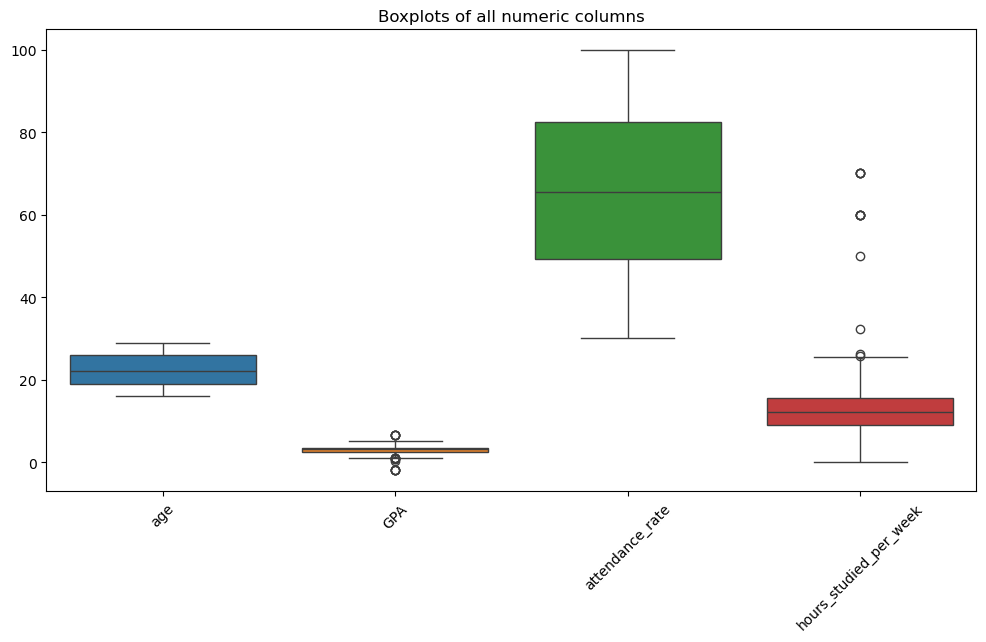

In [779]:
#Lets visulize the data to check for outliers
plt.figure(figsize=(12, 6))
sns.boxplot(df)
plt.title('Boxplots of all numeric columns')
plt.xticks(rotation=45)
plt.show()

From the chart above
- The GPA and the hours_studied_per_week columns show outliers

#### Deliverable 10 : What preprocessing method would you use if GPA had unrealistic values (like -1 or 6)?

    - Since the rows are small, I will remove the rows with such un realistic GPA values

In [782]:
# first let's drop the invalid GPAs that's values less then 0 and greater than 5 point
df = df[(df['GPA'] >= 0) & (df['GPA'] <= 5)]

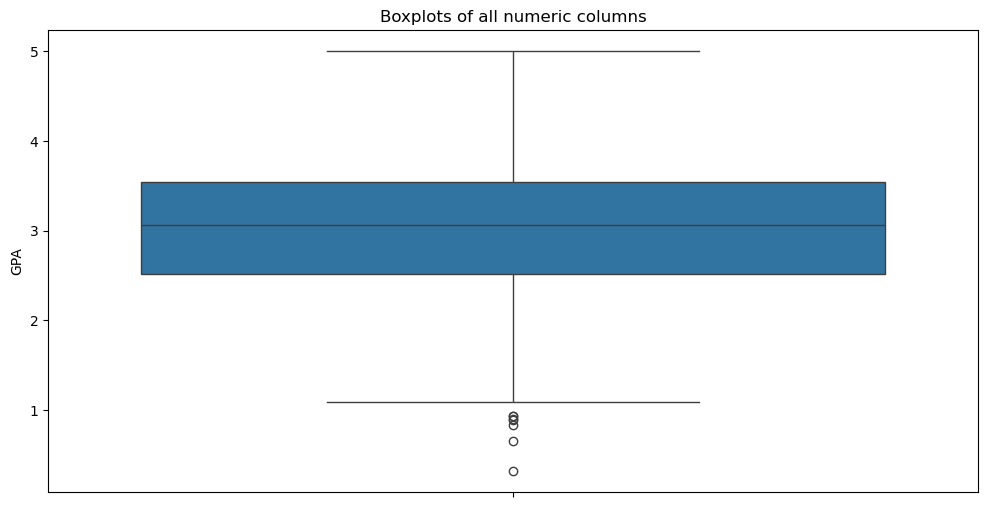

In [783]:
# Let's check for outliers again on the GPA column
plt.figure(figsize=(12, 6))
sns.boxplot(df['GPA'])
plt.title('Boxplots of all numeric columns')
plt.xticks(rotation=45)
plt.show()

In [784]:
# Function to remove outliers for a numeric column using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Keep only rows within the bounds
    df_clean = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_clean

In [785]:
#remove outliers in GPA column
df = remove_outliers(df, 'GPA')

#remove outliers in hours_studied_per_week column
df = remove_outliers(df, 'hours_studied_per_week')

In [786]:
print("After removing GPA outliers:", df.shape)

After removing GPA outliers: (971, 11)


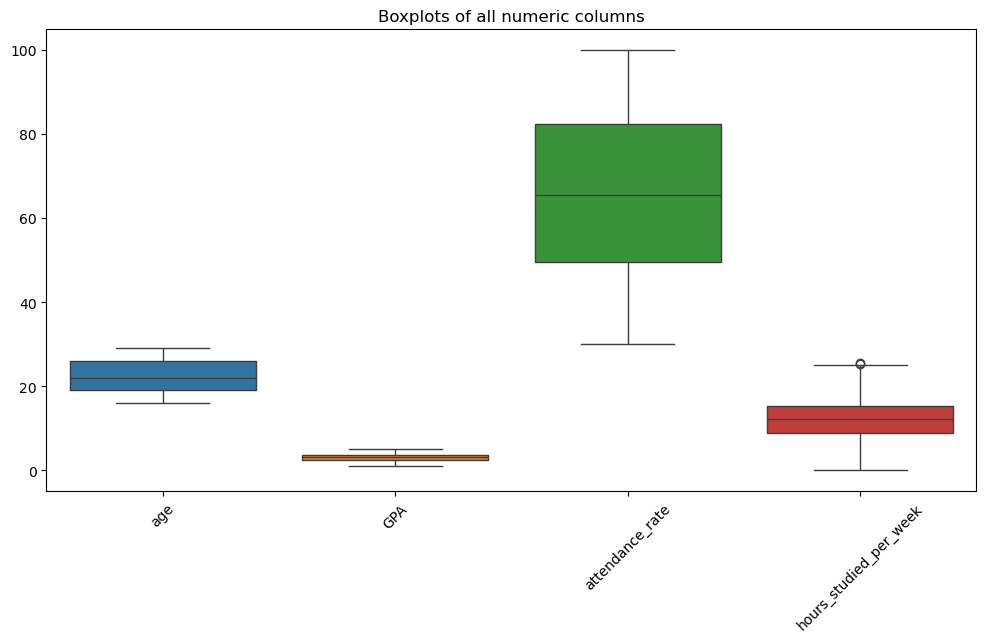

In [787]:
#Lets visulize the data to check for outliers
plt.figure(figsize=(12, 6))
sns.boxplot(df)
plt.title('Boxplots of all numeric columns')
plt.xticks(rotation=45)
plt.show()

#### Checking for class imbalance

In [789]:
dropout_count = df['dropout'].value_counts()
dropout_count

dropout
No     745
Yes    226
Name: count, dtype: int64

The confirm the fact the students are more retained than drop out

In [791]:
# Let's check for the percentages of each class
class_percentages = df['dropout'].value_counts(normalize=True) * 100
print("\nClass percentages:")
print(class_percentages)


Class percentages:
dropout
No     76.725026
Yes    23.274974
Name: proportion, dtype: float64


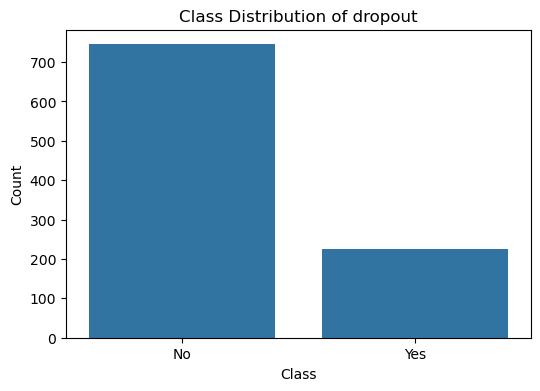

In [792]:
# let's visualize 
plt.figure(figsize=(6, 4))
sns.countplot(x='dropout', data=df)
plt.title(f'Class Distribution of dropout')
plt.ylabel('Count')
plt.xlabel('Class')
plt.show()

#### Let's Visualize

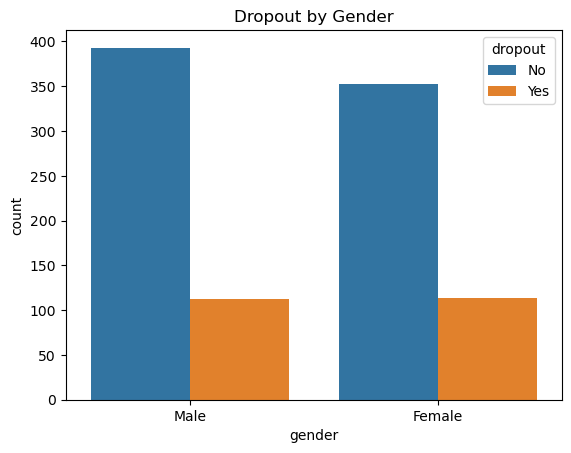

In [794]:
# relationship betwen dropout and gender

sns.countplot(x="gender", hue="dropout", data=df)
plt.title("Dropout by Gender")
plt.show()

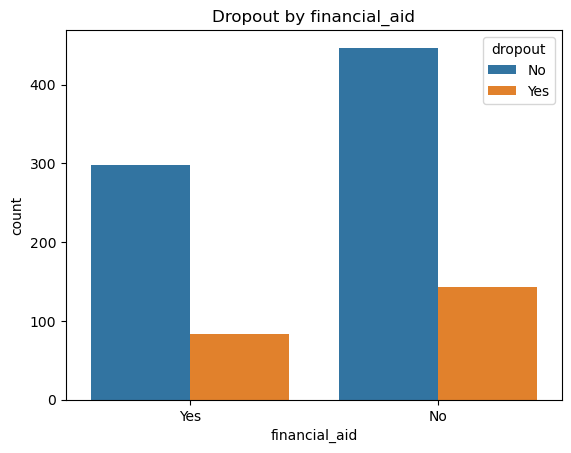

In [795]:
# relationship betwen dropout and financial_aid             

sns.countplot(x="financial_aid", hue="dropout", data=df)
plt.title("Dropout by financial_aid")
plt.show()

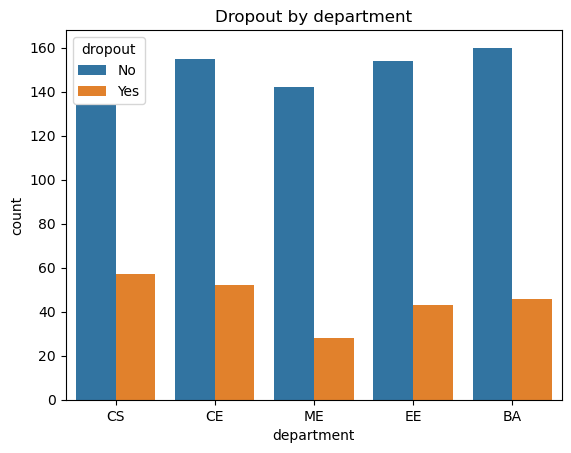

In [796]:
# relationship betwen dropout and financial_aid             

sns.countplot(x="department", hue="dropout", data=df)
plt.title("Dropout by department")
plt.show()


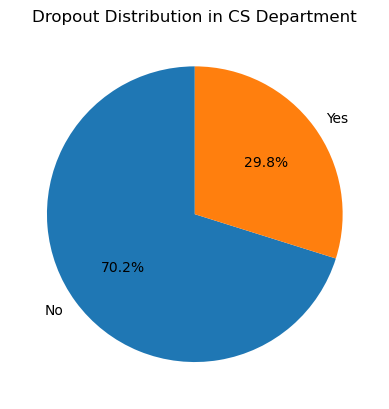

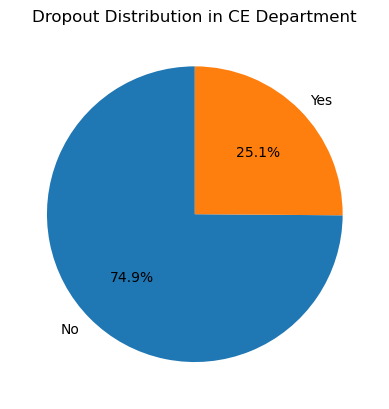

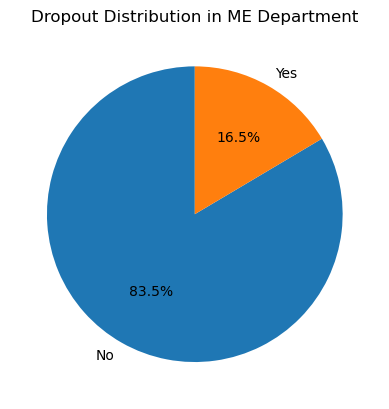

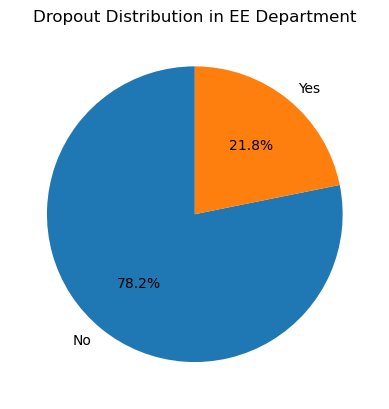

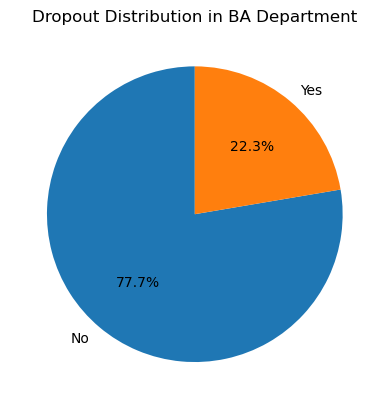

In [797]:
for dept in df['department'].unique():
    subset = df[df['department'] == dept]
    counts = subset['dropout'].value_counts()

    plt.figure()
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
    plt.title(f'Dropout Distribution in {dept} Department')
    plt.show()

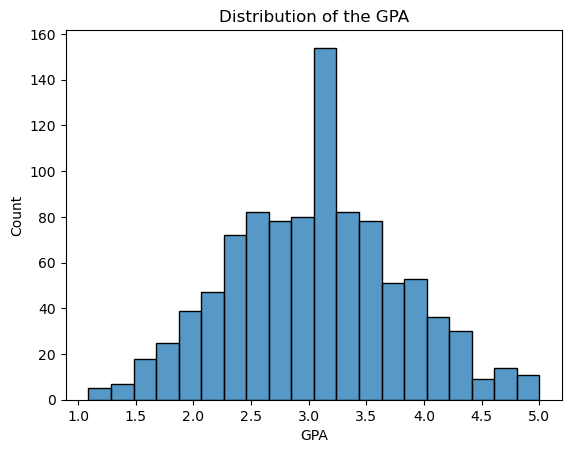

In [798]:
# Lets check the distribution of the continous variables
sns.histplot(x="GPA", data=df)
plt.title("Distribution of the GPA")
plt.show()

The chart above shows that the GPA column is normally distributed which will definetly  help our model

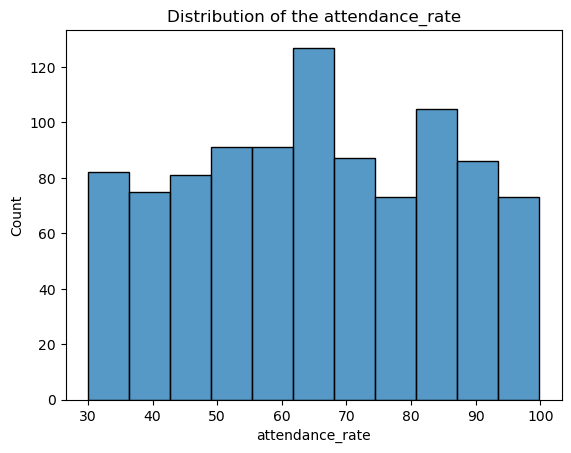

In [800]:
# Lets check the distribution of the continous variables
sns.histplot(x="attendance_rate", data=df)
plt.title("Distribution of the attendance_rate")
plt.show()

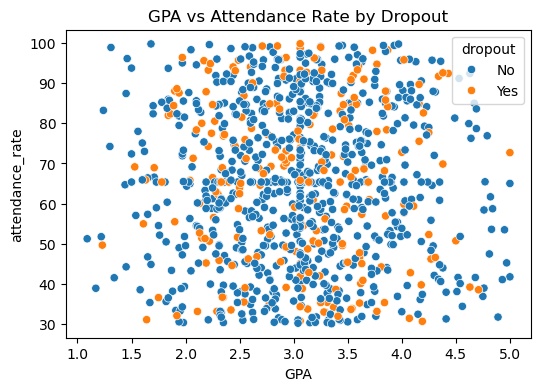

In [801]:
#Lets check the correlation betweenn attendance_rate and the GPA
# GPA vs attendance_rate colored by dropout
plt.figure(figsize=(6,4))
sns.scatterplot(x='GPA', y='attendance_rate', hue='dropout', data=df)
plt.title('GPA vs Attendance Rate by Dropout')
plt.show()

The chart above hows that there is low or no correlation between the two variables

Let's check using the heatmap

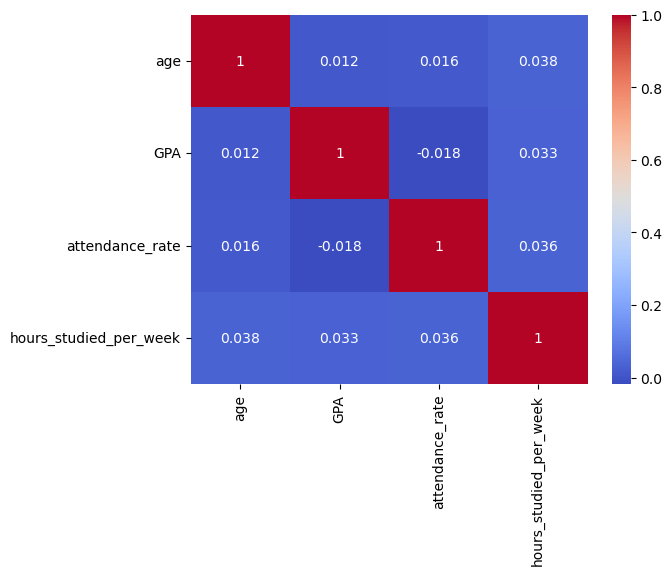

In [803]:
numeric_cols = ['age','GPA','attendance_rate','hours_studied_per_week']
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.show()

#### Deliverables 5: Encoding categorical variables

List of categorical features
- gender
- department
- parent_education_level
- internet_access
- financial_aid
- dropout

After reviewing the dataset
1. We will be using one-hot encoding for the following columns
    - gender
    - department
2. We will be using Ordinal encoding for the following columns
    - parent_education_level
3. We will be using binary encoding for the following columns
    - internet_access
    - financial_aid
    - dropout

In [806]:
# case 1: One-hot encoding
df = pd.get_dummies(
    df,
    columns=['gender', 'department'],
    drop_first=True
)

df.head(3)

,student_id,age,GPA,attendance_rate,financial_aid,parent_education_level,hours_studied_per_week,internet_access,dropout,gender_Male,department_CE,department_CS,department_EE,department_ME
0,S1000,22,3.30,56.83,Yes,Primary,13.4,Yes,No,True,False,True,False,False
1,S1001,19,4.28,64.55,No,Tertiary,10.9,Yes,No,True,False,True,False,False
2,S1002,28,3.90,49.83,Yes,Tertiary,9.0,Yes,No,True,False,True,False,False


In [807]:
 df['parent_education_level'].unique()

array(['Primary', 'Tertiary', 'Secondary'], dtype=object)

In [808]:
# Ordinal encoding
edu_map = {
    'Primary': 1,
    'Secondary': 2,
    'Tertiary': 3,
}
df['parent_education_level'] = df['parent_education_level'].map(edu_map)

In [809]:
# Filling binary categorical columns
binary_cols = ['internet_access','financial_aid', 'dropout']
for col in binary_cols:
    df[col] = df[col].map({'Yes':1,'No':0})

In [810]:
df.head(3)

,student_id,age,GPA,attendance_rate,financial_aid,parent_education_level,hours_studied_per_week,internet_access,dropout,gender_Male,department_CE,department_CS,department_EE,department_ME
0,S1000,22,3.30,56.83,1,1,13.4,1,0,True,False,True,False,False
1,S1001,19,4.28,64.55,0,3,10.9,1,0,True,False,True,False,False
2,S1002,28,3.90,49.83,1,3,9.0,1,0,True,False,True,False,False


In [811]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 971 entries, 0 to 999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   student_id              971 non-null    object 
 1   age                     971 non-null    int64  
 2   GPA                     971 non-null    float64
 3   attendance_rate         971 non-null    float64
 4   financial_aid           971 non-null    int64  
 5   parent_education_level  971 non-null    int64  
 6   hours_studied_per_week  971 non-null    float64
 7   internet_access         971 non-null    int64  
 8   dropout                 971 non-null    int64  
 9   gender_Male             971 non-null    bool   
 10  department_CE           971 non-null    bool   
 11  department_CS           971 non-null    bool   
 12  department_EE           971 non-null    bool   
 13  department_ME           971 non-null    bool   
dtypes: bool(5), float64(3), int64(5), object(1)
mem

In [812]:
# Convert all boolean columns to 1/0
bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].astype(int)

df.head(3)

,student_id,age,GPA,attendance_rate,financial_aid,parent_education_level,hours_studied_per_week,internet_access,dropout,gender_Male,department_CE,department_CS,department_EE,department_ME
0,S1000,22,3.30,56.83,1,1,13.4,1,0,1,0,1,0,0
1,S1001,19,4.28,64.55,0,3,10.9,1,0,1,0,1,0,0
2,S1002,28,3.90,49.83,1,3,9.0,1,0,1,0,1,0,0


#### Deliverable 7: Drop irrelevant or duplicate columns

Now that the we have preprocess the data into numbers which the augorithms will prefer the most

Let's us now go ahead to split the pipeline

1. First, let us split the dataset into X and y, the dataset to feed into the model and the target .
    - We will not be adding the student_id as it is just an identifier, it doesn't have a pattern the model need to be trained on.

In [815]:
X = df.drop(['student_id', 'dropout'], axis=1)
y = df['dropout']

#### Deliverable 8: Split the dataset

    - Use train-test split (e.g., 80/20)

In [817]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y, random_state=45)

In [818]:
print("Original distribution:")
print(y.value_counts(normalize=True) * 100)

Original distribution:
dropout
0    76.725026
1    23.274974
Name: proportion, dtype: float64


In [819]:
print("\nTrain distribution:")
print(y_train.value_counts(normalize=True) * 100)


Train distribution:
dropout
0    76.785714
1    23.214286
Name: proportion, dtype: float64


In [820]:
print("\nTest distribution:")
print(y_test.value_counts(normalize=True) * 100)


Test distribution:
dropout
0    76.54321
1    23.45679
Name: proportion, dtype: float64


After spliting the dataset, then let's go ahead to use StandardScaler on the continuous columns

In [823]:
X.head(3)

,age,GPA,attendance_rate,financial_aid,parent_education_level,hours_studied_per_week,internet_access,gender_Male,department_CE,department_CS,department_EE,department_ME
0,22,3.30,56.83,1,1,13.4,1,1,0,1,0,0
1,19,4.28,64.55,0,3,10.9,1,1,0,1,0,0
2,28,3.90,49.83,1,3,9.0,1,1,0,1,0,0


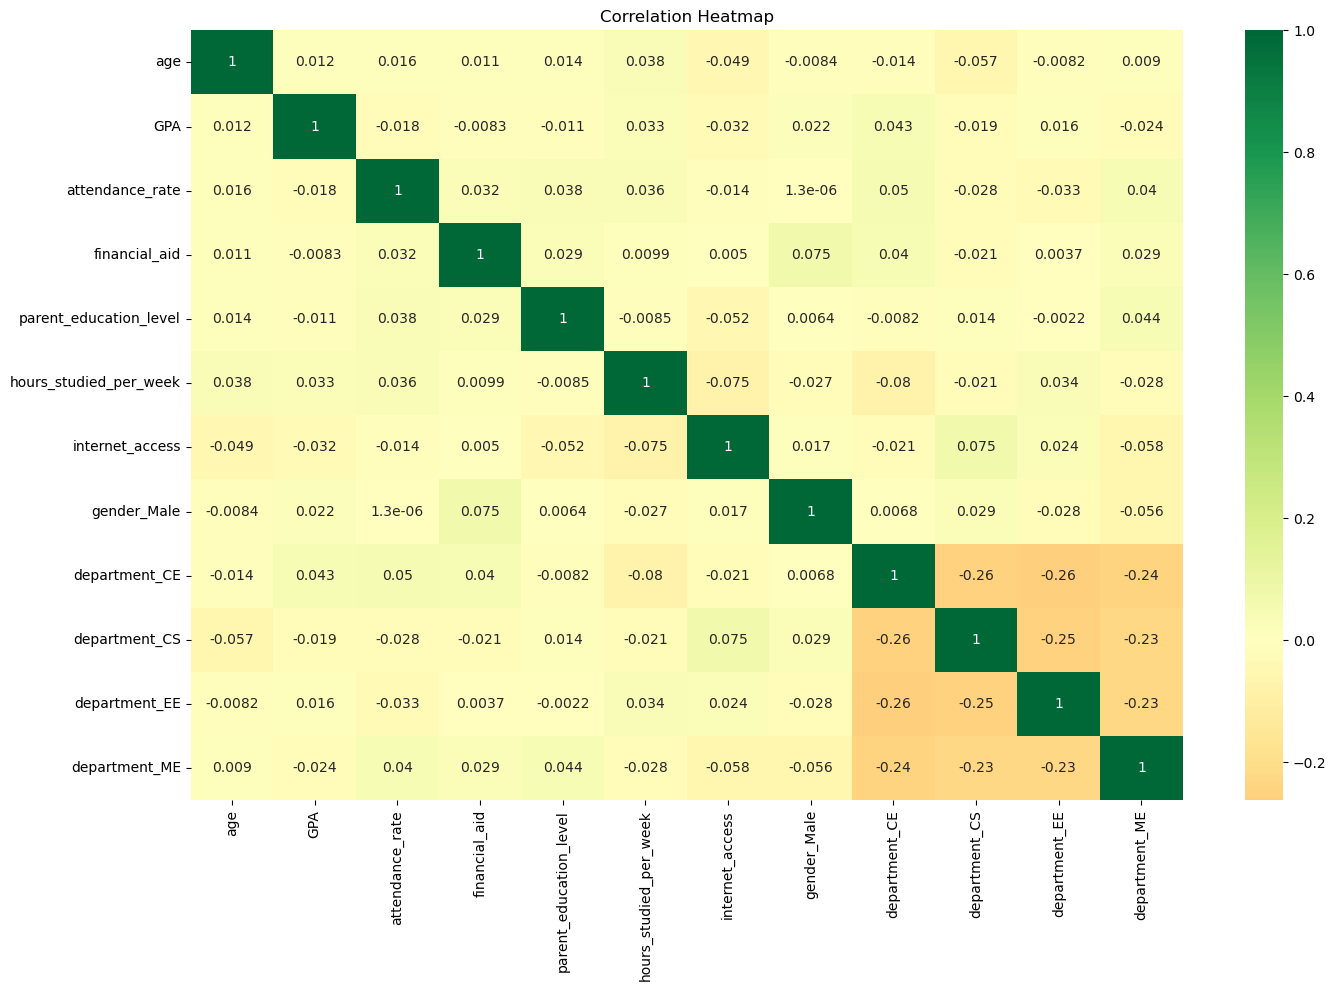

In [824]:

plt.figure(figsize=(16, 10)) 
sns.heatmap(X.corr(), annot=True, cmap='RdYlGn', center=0)
plt.title("Correlation Heatmap")
plt.show()

#### Scale or normalize continuous features

From the Above, we will be sclaing the following columns
    - age
    - GPA
    - attendance_rate
    - parent_education_level ( Beacuse we are scaling the other columns)
    - hours_studied_per_week

In [827]:
scale_cols = ['age', 'GPA', 'attendance_rate', 'hours_studied_per_week', 'parent_education_level']

In [828]:
scaler = StandardScaler()

In [829]:
# fitting on training dataset
X_train[scale_cols] = scaler.fit_transform(X_train[scale_cols])

In [830]:
# fitting on test dataset
X_test[scale_cols] = scaler.transform(X_test[scale_cols])

After scaling the values, we will then go ahead to train the dataset

#### Deliverable 9: How would you balance the dataset if only 20% of students dropped out?
    1. Making use of smote to oversample the minority class

In [833]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

#### Deliverable 11
    How would you handle text input if parent_education_level had free-text entries like “high school”, “college”, “None”?

1. First thing is I will map similar meanings together
       - for example
mapping = {
    'none': 'none',
    'no school': 'none',
    'primary': 'primary',
    'secondary': 'secondary',
    'high school': 'secondary',
    'college': 'tertiary',
    'university': 'tertiary',
    'uni': 'tertiary'
}


df['parent_education_level'] = df['parent_education_level'].map(mapping)

2. Then I will encode using the ordinal encoding

## Training the Dataset

In [837]:
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000)
log_reg.fit(X_train_res, y_train_res)
y_pred_lr = log_reg.predict(X_test)
y_prob_lr = log_reg.predict_proba(X_test)[:,1]

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [839]:
# Random Forest
rf = RandomForestClassifier(class_weight='balanced', n_estimators=500, random_state=42)
rf.fit(X_train_res, y_train_res)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:,1]

In [840]:
# XGBoost
# Calculate scale_pos_weight for imbalance
pos = sum(y_train_res==1)
neg = sum(y_train_res==0)
scale_pos_weight = neg / pos

In [841]:
xgb_model = xgb.XGBClassifier(n_estimators=500, scale_pos_weight=scale_pos_weight, use_label_encoder=False, eval_metric='auc', random_state=42)
xgb_model.fit(X_train_res, y_train_res)
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:,1]

C:\Users\user\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:21:55] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [842]:
#Evaluating the models
def evaluate_model(y_true, y_pred, y_prob, model_name):
    print(f"--- {model_name} ---")
    print(classification_report(y_true, y_pred))
    print("ROC-AUC:", roc_auc_score(y_true, y_prob))
    print("\n")

In [843]:
evaluate_model(y_test, y_pred_lr, y_prob_lr, "Logistic Regression")
evaluate_model(y_test, y_pred_rf, y_prob_rf, "Random Forest")
evaluate_model(y_test, y_pred_xgb, y_prob_xgb, "XGBoost")

--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.73      0.56      0.63       186
           1       0.18      0.32      0.23        57

    accuracy                           0.50       243
   macro avg       0.45      0.44      0.43       243
weighted avg       0.60      0.50      0.54       243

ROC-AUC: 0.4659498207885304


--- Random Forest ---
              precision    recall  f1-score   support

           0       0.78      0.81      0.79       186
           1       0.29      0.26      0.28        57

    accuracy                           0.68       243
   macro avg       0.54      0.53      0.54       243
weighted avg       0.67      0.68      0.67       243

ROC-AUC: 0.5738068289002075


--- XGBoost ---
              precision    recall  f1-score   support

           0       0.75      0.76      0.76       186
           1       0.17      0.16      0.16        57

    accuracy                           0.62       243
  